# **RECOMENDATION SYSTEM RESTORAN MENGGUNAKAN TF-IDF dan COSINE SIMILARITIES**

Kelompok 6 : 
1. Andreean Dharma Arisandi
2. Reynaldi Marchiano
3. Sanggeni Gali Wardhana
4. Teza Marlevi Fajar

Dataset yang kami gunakan adalah hasil srapping pada zomato dan google maps dengan link berikut : 

https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Dataset_final_project_grup6.csv

Pada skema ini akan dilakukan rekomendasi berdasarkan preferensi restoran oleh user yang akan memunculkan restoran dengan review yang paling mirip.

Untuk Penjelasan mengenai EDA hingga Text Preprocessing pada notebook ini tidak dituliskan karena sudah dilakukan pada flow pertama.

# **IMPORTING LIBRARY**


In [1]:
!pip install pysastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 4.9 MB/s 


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


import nltk
from nltk import tokenize
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gzip
import gensim
import logging
from gensim.models import Word2Vec

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **DATA LOADING**

In [4]:
# Loading dataset
data = pd.read_csv('https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Dataset_final_project_grup6.csv')

In [5]:
data.head()

,No,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review
0,1,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...
1,2,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...
2,3,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...
3,4,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...
4,5,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               120 non-null    int64  
 1   Nama Restaurant  120 non-null    object 
 2   Rating           120 non-null    float64
 3   Price            120 non-null    int64  
 4   Daerah           120 non-null    object 
 5   Tipe_1           120 non-null    object 
 6   Tipe_2           120 non-null    object 
 7   Tipe_3           120 non-null    object 
 8   Review           120 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 8.6+ KB


In [7]:
data.drop('No', axis=1, inplace=True)

# **EXPLORATORY DATA ANALYSIS**

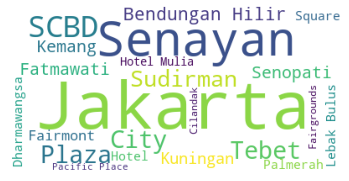

In [8]:
corpus = " ".join(data['Daerah'])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

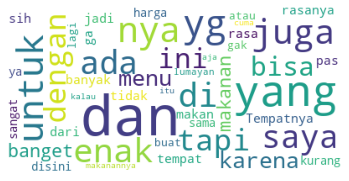

In [9]:
corpus = " ".join(data['Review'])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

# **DATA PREPROCESSING**

In [10]:
lexicon = pd.read_csv('https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Text%20Preprocessing/colloquial-indonesian-lexicon.csv')
formalize = pd.read_csv('https://raw.githubusercontent.com/H8-Assignments-Bay/p2---final-project-group-006/main/Text%20Preprocessing/formalize_word.csv')

In [11]:
lexicon

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0
...,...,...,...,...,...,...,...
15001,gataunya,tidak taunya,0,Ini kaya nenek2 ya beb gataunya agnezz @yugime...,akronim,0,0
15002,gtau,tidak tau,0,Stidaknya mrka may berkarya Dan berusaha yg tr...,akronim,abreviasi,0
15003,gatau,tidak tau,0,Ih gatau malu,akronim,0,0
15004,fans2,fan-fan,0,Jkt48 adalah tempat di mana sesama fans saling...,reduplikasi,naturalisasi,0


In [12]:
formalize

,Slang,Formal
0,bgs,bagus
1,jg,juga
2,Hy,hai
3,dlm,dalam
4,Mgkn,mungkin
5,krn,karena
6,hr,hari
7,dgn,dengan
8,utk,untuk
9,kek,seperti


In [13]:
# Melihat 10 data awal lexicon
dict_lexicon = pd.Series(lexicon.formal.values,index=lexicon.slang).to_dict()
dict_lexicon['brg'] = 'barang'
dict_lexicon['kw']='tiruan'
dict(list(dict_lexicon.items())[:10])

{'aminn': 'amin',
 'eeeehhhh': 'eh',
 'hallo': 'halo',
 'ka': 'kak',
 'kaka': 'kakak',
 'kata2nyaaa': 'kata-katanya',
 'keberpa': 'keberapa',
 'met': 'selamat',
 'netaas': 'menetas',
 'woww': 'wow'}

In [14]:
# Melihat 10 data awal
dict_formalize = pd.Series(formalize.Formal.values,index=formalize.Slang).to_dict()
dict(list(dict_formalize.items())[:10])

{'Hy': 'hai',
 'Mgkn': 'mungkin',
 'bgs': 'bagus',
 'dgn': 'dengan',
 'dlm': 'dalam',
 'hr': 'hari',
 'jg': 'juga',
 'kek': 'seperti',
 'krn': 'karena',
 'utk': 'untuk'}

In [15]:
def clean_text(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"    # emoticons
        u"\U0001F300-\U0001F5FF"    # symbols & pictographs
        u"\U0001F680-\U0001F6FF"    # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
        u"\U00002500-\U00002BEF"    # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"                   # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

    text = text.lower()                                                                                 # membuat huruf menjadi kecil
    text = re.sub(emoj, '', text)                                                                       # remove emoji
    text = re.sub(r'(.)\1{2,}', r'\1', text)                                                            # mengubah huruf berulang diatas 2 kali menjadi 1 saja
    text = re.sub("[0-9]", " ", text)                                                                   # remove numbers
    text = re.sub("(Diterjemahkan oleh Google)", " ", text)                                                                   
    text = re.sub("'s", " ", text) 
    text = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", text)                                                     # remove power character
    text = re.sub("[^A-Za-z\s']"," ", text)  
    text = re.sub("[^\w\s]*[_,.!?#&;:><+-/)/(\'\"]", " ", text)                                         # remove bukan string dan whitespace
    text = ' '.join([re.sub(r'nya$|ny$', '', i) for i in text.split()])                                 # menghapus akhir kata 'nya' atau 'ny'
    text = " ".join(dict_lexicon[w] if w in dict_lexicon else w for w in text.split())                  # replace sesuai dict_lexicon
    text = " ".join(dict_formalize[w] if w in dict_formalize else w for w in text.split())              # replace sesuai dict_formalize
    text = re.sub(" +", " ", text.strip())                                                              # Remove unnecessary white space
    return text

def cleaner(data):
    data['text_preprocessed'] = data['Review'].apply(clean_text)
    return data

In [16]:
cleaner(data)
data.head()

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review,text_preprocessed
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...,fine chocolate pattiserie ini tempat tidak ter...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...,kopi enak kental dan terasa kopi ada berbagai ...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...,tempat mungil dengan nuansa berwarna biru lucu...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...,mie yamin manis special enak sih lebih enak ya...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...,kulit enak crispy terus daging juicy bumbu mer...


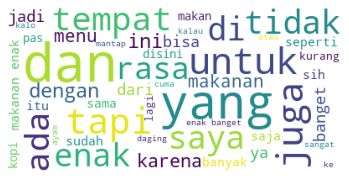

In [17]:
corpus = " ".join(data['text_preprocessed'])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

In [18]:
for i in list(np.random.randint(0,len(data),1)):
    print('Original: ', data.iloc[i,7])
    print('Preprocessed: ', data.iloc[i,8])
    print('-'*50)

Original:  [('Ini tempat Bagus banget, nuansa Jepang kental sekali. Ditambah menu makanannya jelas Japanese banget. Saya coba menu santap ikan bakar makarel dan bawal. Ditambah Sushi  Salmon. Ups jangan lupa tofu nya juga lembut. Dengan sayur pilihan');('Overprice, jualan view & tempat aja. Pesan robatayaki ikan import dari jepang rasa biasa aja. Salmon soup lumayan, agedashi tofu pake ikan cakalang biasa, salmon roll biasa juga.'); ('rasa makanannya lumayan, buat diner okey hanya saja tak ada ruang meetingnya. pakai donk ada 2 meeting room nya biat dikasih 5 bintang'); ('Tempat cukup baik, bbrp ruang private dg view ke Golf course, Resto ini menyajikan makanan Jepang, ada di club house Senayan golf course. Makanan nya baik  pelayanan ok,harga dr makanan dan minuman nya yg terasa mahal, untuk jenis makanan'); ('Tempat elit untuk meeting sambil makan'); ('Tempat bersih dan nyaman dgn view golf'); ('Makanan enak..view bagus..lokasi strategis..parkir susah lebih baik bawa driver'); ('enak

In [19]:
for i in list(np.random.randint(0,len(data),1)):
    print('Original: ', data.iloc[i,7])
    print('Preprocessed: ', data.iloc[i,8])
    print('-'*50)

Original:  [('Pelayanan sangat baik, dan kualitas makanannya juga enak, meskipun variasinya sepertinya bisa ditingkatkan lagi. Tempatnya cozy dan nyaman'); ('Suasana nyaman, menunya banyak pilihan dan rasanya enak'); ('suasana nyaman jadi enak buat makan, rasa makanan pun enak kok'); ('rasa makanan enak'); ('Masakan Enak, ruangan cozy'); ('enak bangettt'); ('Mantap tempatnya'); ('Makanan Italia yang lezat dan pasti sepadan dengan harganya! Ini adalah pertama kalinya saya makan di sini, jadi saya memesan salah satu hidangan khas dan terkejut dengan rasanya yang nikmat namun kompleks. Makanan penutup saya juga menyenangkan'); ('Saya dan suami saya makan malam ulang tahun di Rosso. Tentu saja, kami memiliki makanan dan layanan yang sangat baik. Staf yang melayani kami saat itu sangat ramah dan merekomendasikan kami hidangan utama dan hidangan penutup yang ternyata sangat'); ('Memiliki Sunday Brunch di sini, resto ini lebih pada makanan Italia di hotel shang, makanannya enak, dan paketnya 

In [20]:
for i in range(1):
  print('Before :')
  print(data['Review'][i])
  print('---'*50)
  print('After :')
  print(data['text_preprocessed'][i])

Before :
[('Fine Chocolate & Pattiserie ini tempatnya tidak terlalu besar, interior yang terlihat elegan dan keren. Banyak sekali produk coklat yang dijual di sini mulai dari chocolate box, chocolate bar chocolate by the gram, ice cream, hot chocolate powder, minuman chocolate dan cakes dll. Cake di sini didisplay cantik, rasanya kepingin cobain semuanya deh. Ada area bar tersendiri untuk membuat minuman hot chocolate. Seating area terbatas, hanya ada 3 table saja. Tempat yang nyaman untuk menikmati dessert dan hot chocolate. Saya mencoba : *Java Hot 36% (55k++) - Ini adalah salah satu dari minuman single origin chocolate. Perpaduan milk dan cocoanya sangat pas dan ada hint hazelnutnya juga. Creamy, milky dan chocolatenya terasa rich, bitter sweetnya terasa pas dan mewah. Meskipun kadar coklatnya hanya 36% rasa coklatnya sudah terasa sekali. Minuman ini disajikan panas banget. Enak banget dan recommended.
 *Apple granny (55k++) - dessert ini tampil cute dengan bentuk seperti bola yang 

In [21]:
def stemmer_stopped(text):
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    text = stemmer.stem(text)

    list_stopwords = set(stopwords.words('indonesian'))                             # stopword from nltk
    stopword_factory = StopWordRemoverFactory()                                     # stopword from sastrawi
    stopwords_sastrawi = set(stopword_factory.get_stop_words()) 
    list_stopwords = list_stopwords.union(stopwords_sastrawi)                       # join both stopword

    text = " ".join(w if w not in list_stopwords else '' for w in text.split())
    text = re.sub(" +", " ", text.strip())                                          # Remove unnecessary white space
    return text

def clean_stopword(data):
    data['clean stopword'] = data['text_preprocessed'].apply(stemmer_stopped)
    return data

In [22]:
clean_stopword(data)
data.head()

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review,text_preprocessed,clean stopword
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...


In [23]:
for i in range(1):
  print('Before :')
  print(data['Review'][i])
  print('---'*50)
  print('After :')
  print(data['text_preprocessed'][i])
  print('---'*50)
  print('After Clean Stopword :')
  print(data['clean stopword'][i])

Before :
[('Fine Chocolate & Pattiserie ini tempatnya tidak terlalu besar, interior yang terlihat elegan dan keren. Banyak sekali produk coklat yang dijual di sini mulai dari chocolate box, chocolate bar chocolate by the gram, ice cream, hot chocolate powder, minuman chocolate dan cakes dll. Cake di sini didisplay cantik, rasanya kepingin cobain semuanya deh. Ada area bar tersendiri untuk membuat minuman hot chocolate. Seating area terbatas, hanya ada 3 table saja. Tempat yang nyaman untuk menikmati dessert dan hot chocolate. Saya mencoba : *Java Hot 36% (55k++) - Ini adalah salah satu dari minuman single origin chocolate. Perpaduan milk dan cocoanya sangat pas dan ada hint hazelnutnya juga. Creamy, milky dan chocolatenya terasa rich, bitter sweetnya terasa pas dan mewah. Meskipun kadar coklatnya hanya 36% rasa coklatnya sudah terasa sekali. Minuman ini disajikan panas banget. Enak banget dan recommended.
 *Apple granny (55k++) - dessert ini tampil cute dengan bentuk seperti bola yang 

# **Do the recommendation system**

Dibawah ini terdapat list nama-nama restaurant yang terdapat pada dataset hasil scrapping kami.

In [24]:
nama_restaurant = list(data['Nama Restaurant'].unique())

In [25]:
def get_top_words (max_topwords) :
  top_words = []
  for ix in range(len(data)) :
    count_vec = CountVectorizer()
    matrix = count_vec.fit_transform([data['clean stopword'][ix]])
    counts = pd.DataFrame(matrix.toarray(),columns=count_vec.get_feature_names())
    top=counts.T.sort_values(by=0, ascending=False).head(max_topwords)
    index_top=top.index.tolist()
    join_kolom=" ".join(index_top)
    top_words.append(join_kolom)

  data["kata_top"] = top_words
  return data

Langkah awal untuk melakukan rekomendasi sistem, karena kita akan memmbandingkan restoran dengan review yang paling mirip, maka akan dilakukan pangambilan kata top (sering muncul) dari setiap restaurant. Pengambilan top words dilakukan dengan menggunakan fungsi diatas.

In [26]:
get_top_words (max_topwords=30).head(5)

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,Review,text_preprocessed,clean stopword,kata_top
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,[('Fine Chocolate & Pattiserie ini tempatnya t...,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...,kue chocolate cokelat coba minum cake coklat k...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,[('Kopinya enak. Kental dan terasa kopinya. Ad...,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...,kopi duduk harga ramai malam gor bulungan park...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,[('Tempatnya mungil dengan nuansa berwarna bir...,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...,kopi nyaman coga susu pas lumayan hilir bendun...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,[('mie yamin manis special enak sih lebih enak...,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...,mie ayam makan manis porsi benhil coba yamin s...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,[('Kulitnya Enak Crispy Trs Dagingnya Juicy Bu...,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...,ayam makan harga sambal saos nyaman jangkau uk...


Kemudian tabel diatas adalah contoh table dengan penambahan kolom kata_top yang berisi 30 kata teratas dan dijadikan satu kedalam satu row.

In [27]:
data_con_kata_top = get_top_words (max_topwords=10)

Untuk membuat kolom baru yang akan diolah lebih lanjut menggunakan TF-IDF, kami meenggunakan nilai maximum topwords hanya berjumah sepuluh saja, hal ini kami lakukan untuk menjadikan kata yang muncul terfokus dan tetap mentoleransi kata-kata lain yang merepresentasikan restoran berdasarkan review dari customer sebelumnya.

In [28]:
data_new=data_con_kata_top.drop(['Review'],axis=1)
# df_percent = data_new.sample(frac=1)
df_percent = data_new

In [29]:
df_percent.head()

,Nama Restaurant,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,text_preprocessed,clean stopword,kata_top
0,KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...,kue chocolate cokelat coba minum cake coklat k...
1,Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...,kopi duduk harga ramai malam gor bulungan park...
2,Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...,kopi nyaman coga susu pas lumayan hilir bendun...
3,"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...,mie ayam makan manis porsi benhil coba yamin s...
4,Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...,ayam makan harga sambal saos nyaman jangkau uk...


In [30]:
df_percent.set_index('Nama Restaurant', inplace=True)
indices = pd.Series(df_percent.index)

# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0)
tfidf_matrix = tfidf.fit_transform(df_percent['kata_top'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

- Pada code diatas, kami melakukan tf-idf vectorizer untuk menjadikan setiap kata yang terkandung pada seluruh kolom review menjadi sparse matrix.

- Analyzer word untuk menyesuikan data yang digunakan yaitu kalimat yang berisi string, ngram_range=(1,2) menunjukan bahwa menggunakan tipe unigram dan bigram.

- Cosine similarities digunakan untuk mencari hubungan antar restoran dengan memanfaatkan hasil tf-idf dari kolom kata_top. prinsip dari cosine similarities ini mirip dengan heatmap yang menunjukan nilai kecocokan antara satu restoran dengan seluruh restoran.

In [31]:
tfidf_matrix

<120x1227 sparse matrix of type '<class 'numpy.float64'>'
	with 2280 stored elements in Compressed Sparse Row format>

In [32]:
cosine_similarities.shape

(120, 120)

Diatas adalah hasil cosine similarities berbentuk (120,120) karena terdapat 120 restoran (row) yang akan dicocokan dengan restoran lainnya yang terdapat pada dataset.

In [33]:
df_percent.head()

,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3,text_preprocessed,clean stopword,kata_top
Nama Restaurant,,,,,,,,,
KAKAW Fine Chocolate & Patisserie,3.4,20000,"Senayan, Jakarta",Kafe,Desserts,-,fine chocolate pattiserie ini tempat tidak ter...,fine chocolate pattiserie interior elegan kere...,kue chocolate cokelat coba minum cake coklat k...
Join Kopi Bulungan,3.9,20000,"Blok M, Jakarta",Kopi,-,-,kopi enak kental dan terasa kopi ada berbagai ...,kopi kental asa kopi varian jenis kopi minum i...,kopi duduk harga ramai malam gor bulungan park...
Kopi Coga,4.0,25000,"Bendungan Hilir, Jakarta",Kafe,Kopi,Tea,tempat mungil dengan nuansa berwarna biru lucu...,mungil nuansa warna biru lucu nih wifi stop ko...,kopi nyaman coga susu pas lumayan hilir bendun...
"Mie Keriting Benhil ""Mas Pujo""",3.4,25000,"Bendungan Hilir, Jakarta",Bakmi,-,-,mie yamin manis special enak sih lebih enak ya...,mie yamin manis special sih manis asin si pref...,mie ayam makan manis porsi benhil coba yamin s...
Rocky Rooster,4.2,25000,"Palmerah, Jakarta",Makanan Cepat Saji,-,-,kulit enak crispy terus daging juicy bumbu mer...,kulit crispy daging juicy bumbu resap sambal p...,ayam makan harga sambal saos nyaman jangkau uk...


In [34]:
df_percent.keys()

Index(['Rating', 'Price', 'Daerah', 'Tipe_1', 'Tipe_2', 'Tipe_3',
       'text_preprocessed', 'clean stopword', 'kata_top'],
      dtype='object')

In [35]:
def recommend(name, cosine_similarities=cosine_similarities):
    
    # Create a list to put top restaurants
    recommend_restaurant = []
    
    # Find the index of the restaurant entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from biggest number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top indexes with a similar cosine-sim value
    top_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top restaurants
    for each in top_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    dat_for_filter = pd.DataFrame(columns=['Rating', 'Price', 'Daerah','Tipe_1', 'Tipe_2', 'Tipe_3'])
    
    # Create the top similar restaurants with some of their columns
    for each in recommend_restaurant:
        dat_for_filter = dat_for_filter.append(pd.DataFrame(df_percent[['Rating', 'Price', 'Daerah','Tipe_1', 'Tipe_2', 'Tipe_3']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 6 by the highest rating
    dat_for_filter = dat_for_filter.drop_duplicates(subset=['Rating', 'Price', 'Daerah','Tipe_1', 'Tipe_2', 'Tipe_3'], keep=False)
    dat_for_filter = dat_for_filter.head(7)
    
    print('TOP %s TEMPAT MAKAN/RESTORAN YANG MEMILIKI REVIEW MIRIP %s : ' % (str(len(dat_for_filter)-1), name))
    
    return dat_for_filter[1:]



Setelah itu kita dapat melakukan predict atau rekomendasi beberapa resotran yang memiliki kesesuaian review pelanggan dengan menggunakan fungsi recommend diatas.

In [36]:
recommend('Kopi SSS')

TOP 6 TEMPAT MAKAN/RESTORAN YANG MEMILIKI REVIEW MIRIP Kopi SSS : 


,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3
Warung Fotkop,3.9,40000,"Fatmawati, Jakarta",Kafe,Kopi,-
Nitro Coffee,3.8,50000,"Senopati, Jakarta",Kopi,-,-
LEMONDISCOFISH,4.2,75000,"Kemang, Jakarta",Kopi,Desserts,Ice Cream
Spectrum - Fairmont Jakarta,4.6,650000,"Fairmont Jakarta, Senayan, Jakarta",Barat,-,-
HABITUAL COFFEE & EATERY (Roti Bakar Kemang),3.2,35000,"Bendungan Hilir, Jakarta",Desserts,Makanan Jalanan,-
Cork & Screw Country Club,4.1,300000,"Senayan National Golf Club, Senayan, Jakarta",Eropa,Grill House,Asia


Berdasarkan hasil diatas, kita dapat melihat bahwa hasil rekomendasi dengan menggunakan cosine_similarities menghasilkan beberapa kafe yang memiliki karakteristik mirip dengan Kopi SSS.

Selain itu akan kita coba bandingkan dengan menggunakan wordcloud untuk melihat sebaran data pada restoran preferensi dan restoran pertama yang direkomendasikan

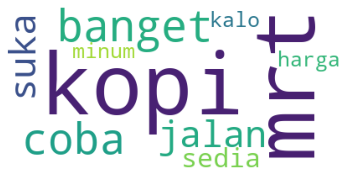

In [37]:
corpus = " ".join(data_con_kata_top[data_con_kata_top["Nama Restaurant"] == "Kopi SSS"]["kata_top"])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)
plt.axis('off')
plt.show()

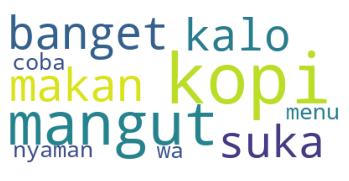

In [38]:
corpus = " ".join(data_con_kata_top[data_con_kata_top["Nama Restaurant"] == "Warung Fotkop"]["kata_top"])
word_cloud = WordCloud(max_words=100, background_color='white', min_font_size=10).generate(corpus)
img = word_cloud.to_image()

fig = plt.figure(1)
plt.imshow(img)

plt.axis('off')
plt.show()

Berdasarkan hasil diatas, dapat terlihat bahwa pada kedua restoran memang memiliki beberapa kesamaan topwords yang muncul yait Kopi dan Banget, sehingga atas dasar tersebut cosine_similarities menunjukan kecocokan yang tinggi.

# **MODEL SAVINGS**

In [39]:
import pickle

# saving
with open('get_top_words.pkl', 'wb') as handle1:
    pickle.dump(get_top_words, handle1, protocol=pickle.HIGHEST_PROTOCOL)

with open('recommender.pkl', 'wb') as handle2:
    pickle.dump(recommend, handle2, protocol=pickle.HIGHEST_PROTOCOL)

with open('cosine_sim.txt', 'wb') as handle3:
    pickle.dump(cosine_similarities, handle3, protocol=pickle.HIGHEST_PROTOCOL)

df_percent.to_csv("data_percent.csv")

# **MODEL LOAD**

In [40]:
with open('get_top_words.pkl', 'rb') as handle1:
    my_topword=pickle.load(handle1)

with open('recommender.pkl', 'rb') as handle2:
    my_recommender=pickle.load(handle2)

with open('cosine_sim.txt', 'rb') as handle3:
    cos_sim=pickle.load(handle3)

# **MODEL INFERENCE & CONCLUSION**

In [44]:
my_recommender("Rumah Makan Surya")

TOP 6 TEMPAT MAKAN/RESTORAN YANG MEMILIKI REVIEW MIRIP Rumah Makan Surya : 


,Rating,Price,Daerah,Tipe_1,Tipe_2,Tipe_3
Bopet Mini,4.4,40000,"Bendungan Hilir, Jakarta",Padang,-,-
Sari Ratu,3.1,40000,"Plaza Senayan, Senayan, Jakarta",Padang,-,-
Mangkok Ku,3.6,40000,"Senayan Park, Senayan, Jakarta",Indonesia,-,-
Toodz House,3.7,100000,"Lebak Bulus, Jakarta",Kopi,Itali,Asia
Andakar,4.1,125000,"Cilandak, Jakarta",Steak,Grill,-
Koko Bogana,4.0,50000,"Senopati, Jakarta",Jawa,-,-


- Berdasarkan inference diatas dapat disimpulkan bahwa model sudah cukup baik dalam melakukan rekomendasi restoran, sebagai contoh restoran Rumah Makan Surya yang menyediakan masakan padang, memiliki similarity dengan Bopet Mini dan Sari Ratu yang juga menyediakan masakan padang, nrekomendasi Mangkok Ku, Toodz House, Andakar dan Koko Bogana dapat muncul karena kemungkinan dataset yang kurang banyak pada tipe masakan padang sehingga dapat muncul restoran lain yang mungkin tidak memiliki tipe yang sama. Kesalahan rekomendasi seperti ini juga dapat terjadi pada rekomendasi restoran lain.

- Untuk mengatasi hal tersebut, pada next improvement, mungkin kami akan melakukan penambahan dataset dari setiap tipe restaurant untuk memunculkan rekomendasi yang lebih mirip.